<a href="https://colab.research.google.com/github/BisginLab/AndroidPrediction/blob/main/FullDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Merge the data rows with their corresponding labels


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
labels = pd.read_csv('label.csv')
contextual_data = pd.read_csv('ContextualDataDescriptionWhatsNew-part1.csv')

# Check the first few rows of each file
print("Labels Data:")
print(labels.head())
print("\nContextual Data:")
print(contextual_data.head())

# Strip leading/trailing spaces from keys if necessary
labels['PackageName'] = labels['PackageName'].str.strip()
contextual_data['pkgname'] = contextual_data['pkgname'].str.strip()

# Merge the dataframes on the package name columns
merged_data = pd.merge(
    contextual_data,
    labels,
    left_on='pkgname',
    right_on='PackageName',
    how='inner'
)

# Check the merged data
print("\nMerged Data:")
print(merged_data.head())
print("\nMerged Data Label Counts:")
print(merged_data['Label'].value_counts())


Labels Data:
                 PackageName  Label
0         com.catdaddy.cat22      0
1    com.king.candycrushsaga      0
2  com.king.scrubbydubbysaga      0
3  com.supercell.clashroyale      0
4       com.supercell.hayday      0

Contextual Data:
                                pkgname  \
0                          com.photoapp   
1      com.bitbybitlabs.sleephelperfree   
2                          com.sonidosm   
3  com.bitbybitlabs.sidesplittingquotes   
4    com.ionicframework.shockwave349163   

                                         Description  \
0  ['The user can login through Instagram account...   
1  ['Say "Goodnight!" to your sleepless nights! W...   
2  ['Have you thought about movie characters stor...   
3  ['Having a bad day? Need a laugh? Just need a ...   
4  ["This app was first inspired by Sheldon Coope...   

                                            WhatsNew  
0                                                 []  
1                             ['minor improveme

# Remove non English, and empty descriptions

In [ ]:
!pip install langdetect

In [ ]:
import pandas as pd
from langdetect import detect, DetectorFactory
from collections import Counter

# Ensure language detection consistency
DetectorFactory.seed = 0


# Count empty descriptions
empty_count = merged_data['Description'].apply(lambda x: x == "[]").sum()

# Language detection for non-empty descriptions
languages = []
for description in merged_data['Description']:
    if description and description != "[]":
        try:
            lang = detect(str(description))
            languages.append(lang)
        except:
            languages.append('unknown')

# Count occurrences of each language
language_counter = Counter(languages)

# Output stats
print(f"Number of empty descriptions: {empty_count}")
print("Languages used in descriptions:")
for lang, count in language_counter.items():
    print(f"{lang}: {count}")

Number of empty descriptions: 100
Languages used in descriptions:
en: 95867
es: 2417
ja: 732
tr: 1359
pt: 857
ru: 2055
nl: 172
id: 1926
de: 673
fr: 1152
it: 632
vi: 535
ko: 564
ca: 91
bn: 649
bg: 250
so: 316
ar: 668
sw: 35
af: 25
zh-cn: 48
sv: 104
da: 38
pl: 276
mk: 15
hr: 145
fa: 87
et: 78
zh-tw: 62
th: 431
no: 47
ro: 103
fi: 19
he: 119
sq: 25
uk: 48
unknown: 36
lt: 22
cy: 8
sl: 22
hi: 47
hu: 66
cs: 95
el: 132
ur: 12
ml: 12
tl: 51
mr: 25
sk: 47
ta: 68
kn: 13
pa: 5
lv: 7
te: 19
ne: 4
gu: 5


In [ ]:
from langdetect import detect, DetectorFactory, LangDetectException
# Create a cleaned dataset with English-only and non-empty descriptions
def is_english(description):
    try:
        return detect(str(description)) == 'en'
    except LangDetectException:
        return False

cleaned_data = merged_data[(merged_data['Description'] != "[]") & (merged_data['Description'].apply(is_english))]



In [ ]:
cleaned_data.to_csv("cleaned_data.csv")

In [ ]:
merged_data= pd.read_csv("cleaned_data.csv")

In [ ]:
len(merged_data)

96370

In [ ]:
cleaned_data=merged_data

# Preliminary Analysis
## Distribution of labels & Word Count

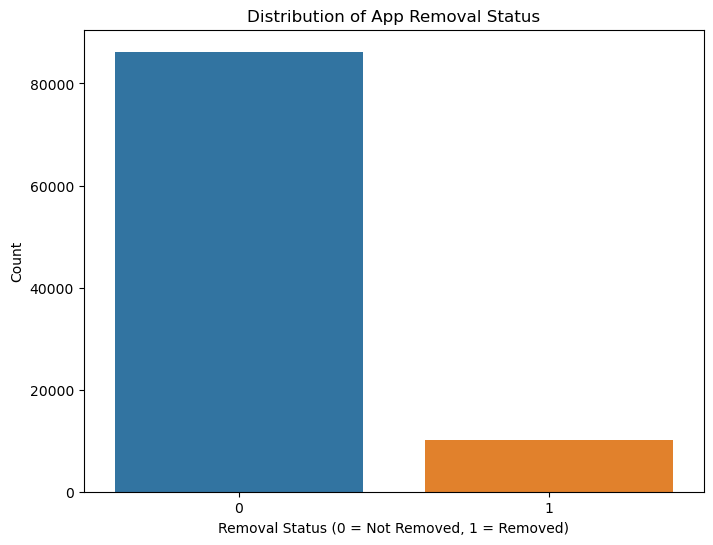


Average Word Count in Descriptions:
Label
0    194.846621
1    208.525906
Name: WordCount, dtype: float64


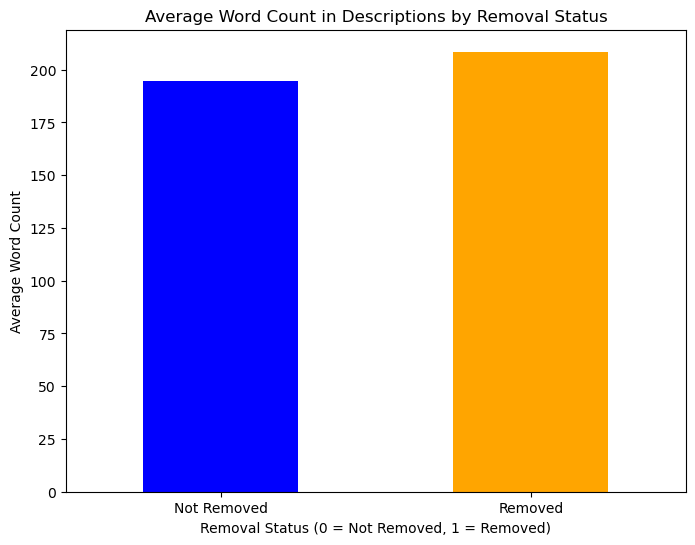

In [ ]:
# Plotting the distribution of labels
plt.figure(figsize=(8, 6))
sns.countplot(x=cleaned_data['Label'])
plt.title('Distribution of App Removal Status')
plt.xlabel('Removal Status (0 = Not Removed, 1 = Removed)')
plt.ylabel('Count')
plt.show()

# Calculate the word count in descriptions
cleaned_data['WordCount'] = cleaned_data['Description'].apply(lambda x: len(str(x).split()))

# Calculate average word count for each label
average_word_count = cleaned_data.groupby('Label')['WordCount'].mean()

print("\nAverage Word Count in Descriptions:")
print(average_word_count)

# Plotting average word count
average_word_count.plot(kind='bar', color=['blue', 'orange'], figsize=(8, 6))
plt.title('Average Word Count in Descriptions by Removal Status')
plt.xlabel('Removal Status (0 = Not Removed, 1 = Removed)')
plt.ylabel('Average Word Count')
plt.xticks([0, 1], ['Not Removed', 'Removed'], rotation=0)
plt.show()

## TF-IDF

In [ ]:

data_removed = cleaned_data[cleaned_data['Label'] == 1]
data_not_removed = cleaned_data[cleaned_data['Label'] == 0]

from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def top_tfidf_words(tfidf_matrix, feature_names, top_n=10):
    sorted_indices = np.argsort(tfidf_matrix.toarray()).flatten()[::-1]
    top_indices = sorted_indices[:top_n]
    top_terms = [(feature_names[i], tfidf_matrix[0, i]) for i in top_indices if tfidf_matrix[0, i] > 0]
    return top_terms

# TF-IDF Vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000, min_df=2, ngram_range=(1, 2))

# Compute TF-IDF for 'Removed' apps
tfidf_removed = tfidf_vectorizer.fit_transform(data_removed['Description'].fillna(''))
feature_names_removed = tfidf_vectorizer.get_feature_names_out()

# Compute TF-IDF for 'Not Removed' apps
tfidf_not_removed = tfidf_vectorizer.fit_transform(data_not_removed['Description'].fillna(''))
feature_names_not_removed = tfidf_vectorizer.get_feature_names_out()

# Get top TF-IDF words
top_words_removed = top_tfidf_words(tfidf_removed, feature_names_removed, top_n=15)
top_words_not_removed = top_tfidf_words(tfidf_not_removed, feature_names_not_removed, top_n=15)

# Print results
print("Top TF-IDF words for removed apps:")
for word, score in top_words_removed:
    print(f"{word}: {score:.4f}")

print("\nTop TF-IDF words for not removed apps:")
for word, score in top_words_not_removed:
    print(f"{word}: {score:.4f}")

Top TF-IDF words for removed apps:
text: 0.0605
button: 0.0521

Top TF-IDF words for not removed apps:
like: 0.0147


## Sentiment Analysis

In [ ]:
!pip install textblob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.3/624.3 kB 849.3 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 883.9 kB/s eta 0:00:0000:0100:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7


Sentiment Analysis Summary:
Removed Apps Sentiment Mean: 0.23172684657733525
Not Removed Apps Sentiment Mean: 0.20622303547675253


/usr/local/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


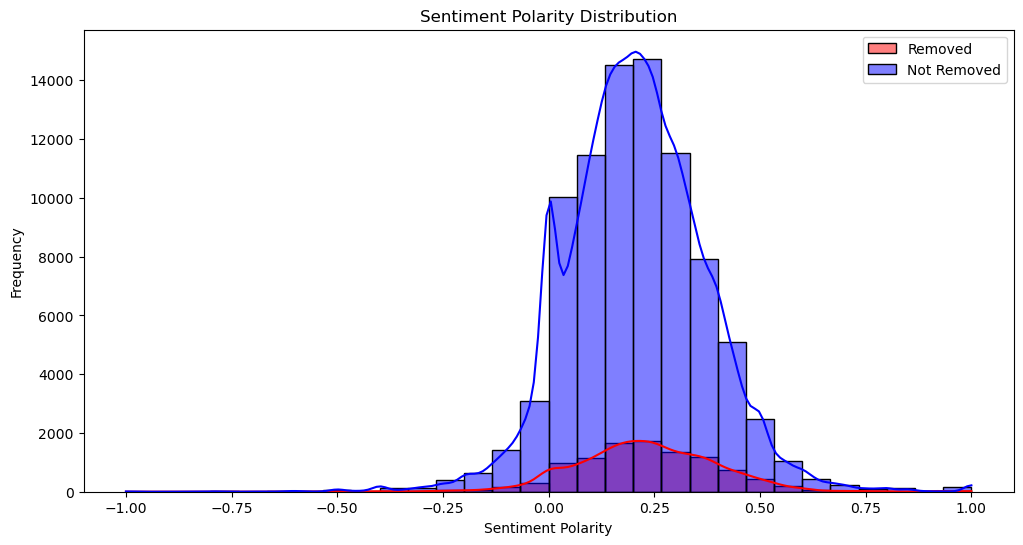

In [ ]:
from textblob import TextBlob
import pandas as pd
import matplotlib.pyplot as plt

# Function to calculate sentiment polarity
def calculate_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply sentiment analysis to descriptions
merged_data['Sentiment'] = merged_data['Description'].fillna('').apply(calculate_sentiment)

# Separate sentiment scores by label
sentiment_removed = merged_data[merged_data['Label'] == 1]['Sentiment']
sentiment_not_removed = merged_data[merged_data['Label'] == 0]['Sentiment']

# Summary statistics
print("Sentiment Analysis Summary:")
print("Removed Apps Sentiment Mean:", sentiment_removed.mean())
print("Not Removed Apps Sentiment Mean:", sentiment_not_removed.mean())

# Plot the sentiment distributions
plt.figure(figsize=(12, 6))
sns.histplot(sentiment_removed, bins=30, color='red', label='Removed', kde=True)
sns.histplot(sentiment_not_removed, bins=30, color='blue', label='Not Removed', kde=True)
plt.title('Sentiment Polarity Distribution')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Generate embeddings for app descriptions using DistilBERT
## NB: Analysis initially done on a subset of the data and later on all the data


In [ ]:
import pandas as pd
from transformers import DistilBertModel, DistilBertTokenizer
import torch
import numpy as np

# Load DistilBERT model and tokenizer
model = DistilBertModel.from_pretrained('distilbert-base-uncased')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Sample a small subset of the cleaned data
small_data = cleaned_data #.sample(n=10000, random_state=0)  # changed the code to work on all data

# Function to generate embeddings
def embed_text(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Generate embeddings with progress tracking
embeddings_list = []
for idx, text in enumerate(small_data['Description'].fillna('')):
    embedding = embed_text(str(text))
    embeddings_list.append(embedding)
    print(f"Created {idx + 1}/{len(small_data)} embeddings")

# Convert list to DataFrame column
small_data['Embeddings'] = embeddings_list

# Convert embeddings into a matrix
embeddings_matrix = np.stack(small_data['Embeddings'].values)

# Output the embeddings
print(embeddings_matrix)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Created 1/96370 embeddings
Created 2/96370 embeddings
Created 3/96370 embeddings
Created 4/96370 embeddings
Created 5/96370 embeddings
Created 6/96370 embeddings
Created 7/96370 embeddings
Created 8/96370 embeddings
Created 9/96370 embeddings
Created 10/96370 embeddings
Created 11/96370 embeddings
Created 12/96370 embeddings
Created 13/96370 embeddings
Created 14/96370 embeddings
Created 15/96370 embeddings
Created 16/96370 embeddings
Created 17/96370 embeddings
Created 18/96370 embeddings
Created 19/96370 embeddings
Created 20/96370 embeddings
Created 21/96370 embeddings
Created 22/96370 embeddings
Created 23/96370 embeddings
Created 24/96370 embeddings
Created 25/96370 embeddings
Created 26/96370 embeddings
Created 27/96370 embeddings
Created 28/96370 embeddings
Created 29/96370 embeddings
Created 30/96370 embeddings
Created 31/96370 embeddings
Created 32/96370 embeddings
Created 33/96370 embeddings
Created 34/96370 embeddings
Created 35/96370 embeddings
Created 36/96370 embeddings
C

In [ ]:
import pickle

# Save using pickle
with open('embeddings_matrix_full.pkl', 'wb') as f:
    pickle.dump(embeddings_matrix, f)


In [ ]:
# Load using pickle
import pickle
with open('embeddings_matrix_full.pkl', 'rb') as f:
    embeddings_matrix = pickle.load(f)

# Clustering of App Descriptions

In [ ]:
!pip install threadpoolctl==3.2.0
!pip install numpy==1.26.2
!pip install --upgrade scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 1.0 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.26.2 which is incompatible.


[[-0.30474985  0.10547844  0.323246   ... -0.19246301  0.6539737
   0.06097542]
 [ 0.08296841  0.37629408  0.14891823 ...  0.03478605  0.02139087
  -0.13415858]
 [-0.12544505  0.01696572  0.5330961  ... -0.1610907  -0.0783253
  -0.17706007]
 ...
 [ 0.03989823 -0.07319538  0.5190769  ... -0.03328139 -0.0263776
  -0.06926566]
 [-0.10778404  0.1329093   0.67728406 ... -0.13501398  0.02987455
  -0.15408947]
 [-0.13744068  0.16449057  0.51883304 ... -0.0451833   0.00739147
  -0.05880051]]
[[-2.0126793   0.2257225  -0.7772171  ... -1.3756444   5.427285
   1.1548581 ]
 [ 0.8913159   2.66926    -1.8628857  ...  1.0591404  -0.22350898
  -0.08265392]
 [-0.6696933  -0.5729174   0.5296752  ... -1.0395162  -1.1142628
  -0.35472906]
 ...
 [ 0.56872183 -1.3864304   0.44236726 ...  0.3298544  -0.6502196
   0.3288878 ]
 [-0.53741294  0.47322786  1.4276409  ... -0.7601258  -0.1477252
  -0.20905276]
 [-0.7595401   0.7581819   0.44084868 ...  0.20233536 -0.34856412
   0.39525625]]
[2 3 4 ... 4 4 4]


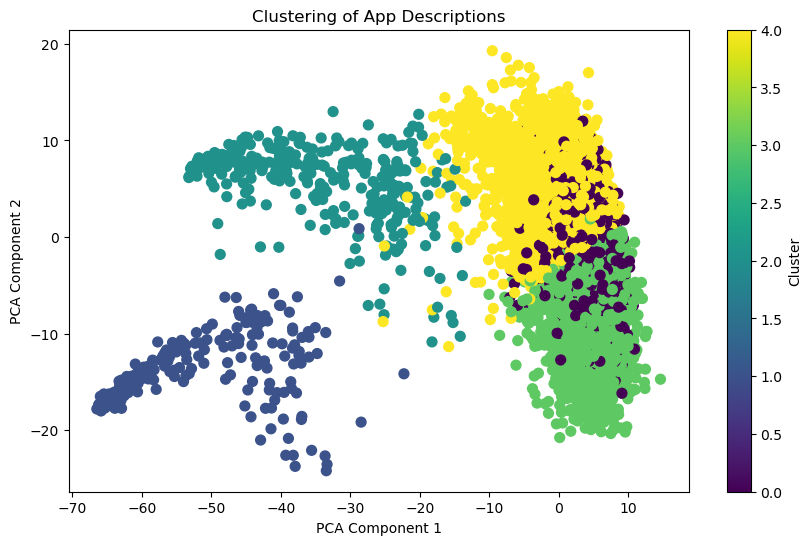

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Ensure there are no NaN values in the embeddings
embeddings_matrix = np.nan_to_num(embeddings_matrix)
print(embeddings_matrix)
# Standardize embeddings
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings_matrix)
print(embeddings_scaled)
# Apply K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=0)
cluster_labels = kmeans.fit_predict(embeddings_scaled)
print(cluster_labels)
# Add cluster labels to the data
small_data['Cluster'] = cluster_labels

# Use PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_scaled)

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.title('Clustering of App Descriptions')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

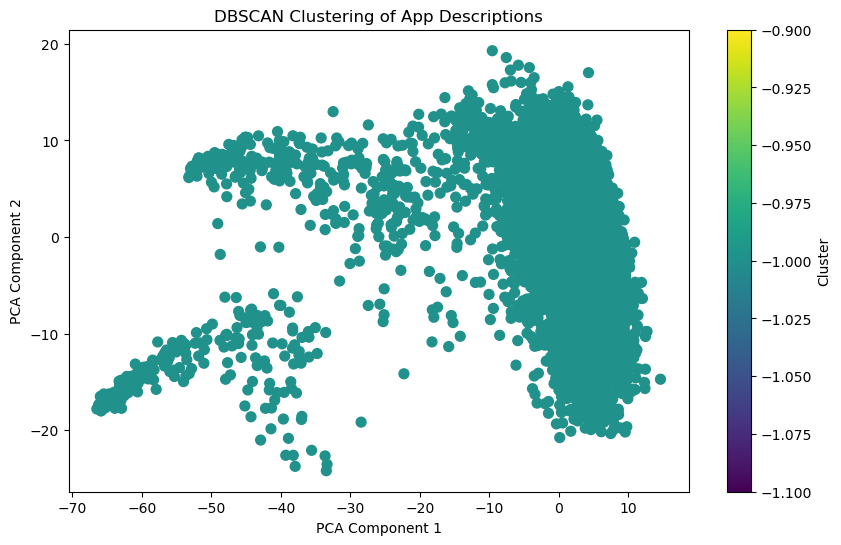

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Ensure no NaNs in the embeddings
embeddings_matrix = np.nan_to_num(embeddings_matrix)

# Standardize embeddings
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings_matrix)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples as needed
cluster_labels = dbscan.fit_predict(embeddings_scaled)

# Add cluster labels to the data
small_data['Cluster'] = cluster_labels

# Use PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_scaled)

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.title('DBSCAN Clustering of App Descriptions')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

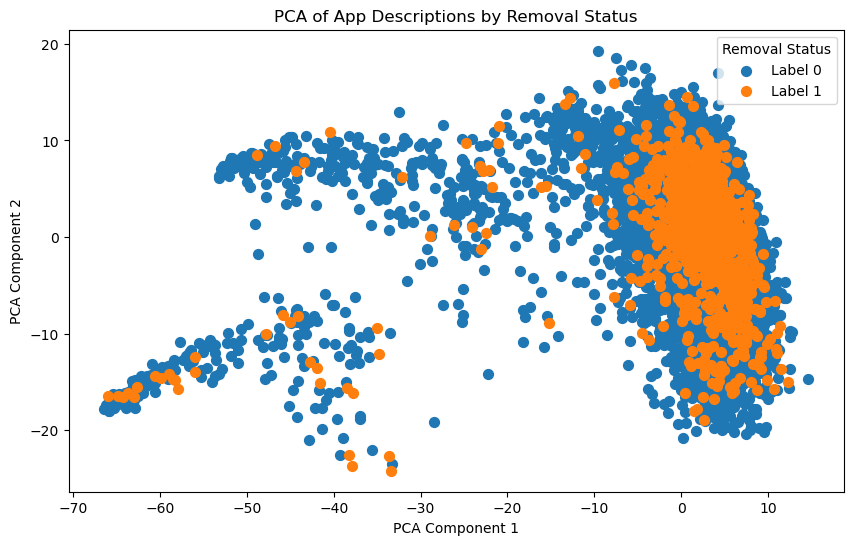

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from sklearn.preprocessing import StandardScaler

# Ensure there are no NaN values in the embeddings
embeddings_matrix = np.nan_to_num(embeddings_matrix)

# Standardize embeddings
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings_matrix)

# Use PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_scaled)

# Plot using two colors for labels
plt.figure(figsize=(10, 6))
for label in [0, 1]:
    subset = reduced_embeddings[small_data['Label'] == label]
    plt.scatter(subset[:, 0], subset[:, 1], s=50, label=f'Label {label}')

plt.title('PCA of App Descriptions by Removal Status')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Removal Status', loc='upper right')
plt.show()

# Cosine Similarity Analysis

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Calculate cosine similarity matrix
similarity_matrix = cosine_similarity(embeddings_matrix)

# Function to check similarity and removal status
def analyze_similarity(similarity_matrix, data):
    same_status_count = 0
    different_status_count = 0
    threshold = 0.8  # Define a threshold for "similar" descriptions

    # Iterate over pairs of descriptions
    for i in range(len(similarity_matrix)):
        for j in range(i + 1, len(similarity_matrix)):  # Avoid duplicate comparisons
            if similarity_matrix[i, j] > threshold:
                if data.iloc[i]['Label'] == data.iloc[j]['Label']:
                    same_status_count += 1
                else:
                    different_status_count += 1

    return same_status_count, different_status_count

# Analyze similarity and removal status
same_status_count, different_status_count = analyze_similarity(similarity_matrix, small_data)

# Print results
print(f"Number of similar pairs with same removal status: {same_status_count}")
print(f"Number of similar pairs with different removal status: {different_status_count}")

Number of similar pairs with same removal status: 28879629
Number of similar pairs with different removal status: 6681071


# Classification

In [ ]:
import pandas as pd
cleaned_data = pd.read_csv("cleaned_data.csv")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Prepare features and target variable
X = embeddings_matrix
y = cleaned_data['Label']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Initialize and train logistic regression model
model = LogisticRegression(max_iter=1000, random_state=0)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

In [ ]:
# Calculate the baseline accuracy
baseline_accuracy = y.value_counts(normalize=True).max()

print(f"Baseline Accuracy: {baseline_accuracy:.2f}")
from sklearn.metrics import precision_recall_fscore_support

# Assume majority class prediction
majority_class = y.mode()[0]
y_pred_majority = [majority_class] * len(y)

# Calculate precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(y, y_pred_majority, average='weighted')
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y, y_pred_majority, average='macro')

print(f"Weighted Precision: {precision:.2f}")
print(f"Weighted Recall: {recall:.2f}")
print(f"Weighted F1-Score: {f1:.2f}")

print(f"Macro Precision: {precision_macro:.2f}")
print(f"Macro Recall: {recall_macro:.2f}")
print(f"Macro F1-Score: {f1_macro:.2f}")

Baseline Accuracy: 0.90
Weighted Precision: 0.80
Weighted Recall: 0.90
Weighted F1-Score: 0.85
Macro Precision: 0.45
Macro Recall: 0.50
Macro F1-Score: 0.47


/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Prepare features and target variable
X = embeddings_matrix
y = cleaned_data['Label']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)


Accuracy: 0.85
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.91      0.92     17255
           1       0.31      0.35      0.32      2019

    accuracy                           0.85     19274
   macro avg       0.61      0.63      0.62     19274
weighted avg       0.86      0.85      0.85     19274



In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Prepare features and target variable
X = embeddings_matrix
y = cleaned_data['Label']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Prepare features and target variable
X = embeddings_matrix
y = small_data['Label']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Initialize and train the K-Nearest Neighbors model
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)
